# (O modelo proposto não bate com os dados)

# Identificação e Validação do modelo linear da taxa p(t)


Os dados de entrada correspondem à resposta em frequência obtidos com o script `analise_resposta_em_freq.ipynb`.
Será analisada a taxa `p` variação do ângulo de rolagem.

In [1]:
import matplotlib
matplotlib.use('TkAgg')  # Configurar o backend para TkAgg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid, quad
import scipy.optimize as optimize
from myfunctions import *
from numpy.random import uniform
import pickle

In [2]:
# Carrega os dados de 'dados/freq_rad_p_rate.txt'
df_freq = pd.read_csv('dados/freq_rad_s_p_rate.txt')
freq_rad = df_freq.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/modulo_dB_p_rate.txt'
df_modulo = pd.read_csv('dados/modulo_dB_p_rate.txt')
modulo_dB = df_modulo.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/fase_rad_p_rate.txt'
df_fase = pd.read_csv('dados/fase_rad_p_rate.txt')
fase_deg = df_fase.iloc[:, 0].astype(float)

# Modelo da dinâmica da taxa p
$$
\dfrac{P(s)}{U(s)}=\dfrac{K_2se^{-\tau_2 s}}{s^2+c_1s+c_2}
$$

Ref: Watcharapol Saengphet Sarul Sakulthong, Suradet Tantrairatn. Frequency
response system identification and flightcontroller tuning for quadcopter uav.
In 2018 Third International Conference on Engineering Science and Innovative
Technology (ESIT).

O protótipo do modelo linear identificado para $P(s)$ é:
$$
(s^2+c_1s+c_2)P(s)=K_2se^{-\tau_2 s}U(s)
$$
$$
s^2P(s)+c_1sP(s)+c_2P(s)=K_2se^{-\tau s}U(s)
$$
Aplicando Transformada Inversa de Laplace, obtemos:
$$
\ddot{p}(t)+c_1\dot{p}(t)+c_2p(t)=K_2\dot{u}(t-\tau_2)
$$
Escolhendo como variáveis de estado $x_1(t)=p(t)$ e $x_2(t)=\dot{p}(t)$, temos;
$$
\begin{align*}
\dot{x}_1&=x_2\\
\dot{x}_2&=-c_1x_2-c_2x_1+\hat{u},
\end{align*}
$$
onde $\hat{u}(t):=K_2\dot{u}(t-\tau_2)$. 

# Ajuste dos parâmetros do modelo proposto
**Objetivo**: 

* Ajustar os parâmetros do modelo utilizando mínimos quadrados com os dados de referência. 
* Para isso utlizamos os mesmos dados utilizados para gerar a resposta em frequência

Precisamos dos dados:

1. Carregar dados dos arquivs txt,
2. Recortar os dados,
3. Ajustamos os dados utilizando mínimos quadrados.

---

1. Carregar dados dos arquivs txt.

In [3]:
# carregamos os dados de 'dados/t_controle.txt', que contém o tempo de controle
df_t_controle = pd.read_csv('dados/t_controle.txt')
t_controle = df_t_controle.iloc[:, 0].astype(float).to_numpy()
# carregamos os dados de 'dados/controle.txt', que contém o sinal de controle
df_controle = pd.read_csv('dados/controle.txt')
controle = df_controle.iloc[:, 0].astype(float).to_numpy()
# carregamos os dados de 'dados/vav0.txt', que contém a velocidade angular de rolagem
df_vav0 = pd.read_csv('dados/vav0.txt')
vav0 = df_vav0.iloc[:, 0].astype(float).to_numpy()

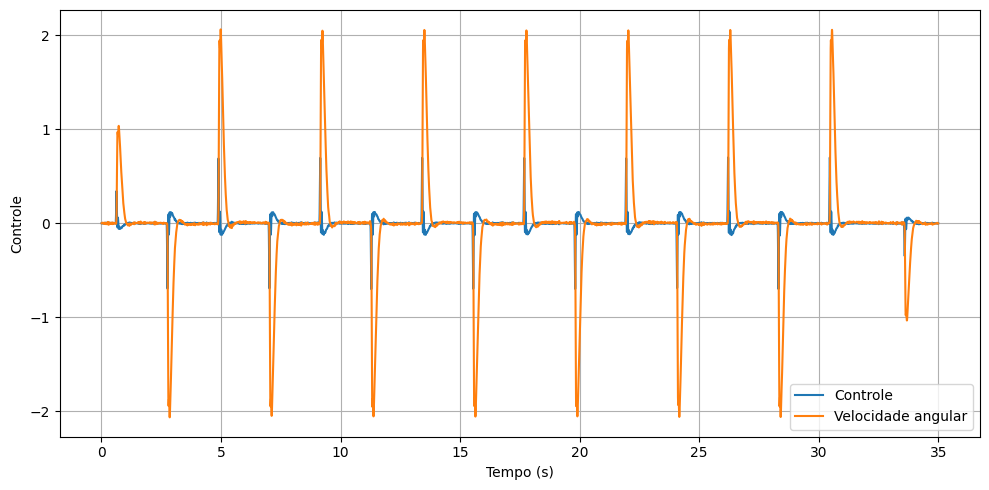

In [4]:
# plotamos os dados
plt.figure(figsize=(10, 5))
plt.plot(t_controle, controle, label='Controle')
plt.plot(t_controle, vav0, label='Velocidade angular')
plt.grid()
plt.xlabel('Tempo (s)')
plt.ylabel('Controle')
plt.legend()
plt.tight_layout()
plt.show()

2. Recortar os dados.

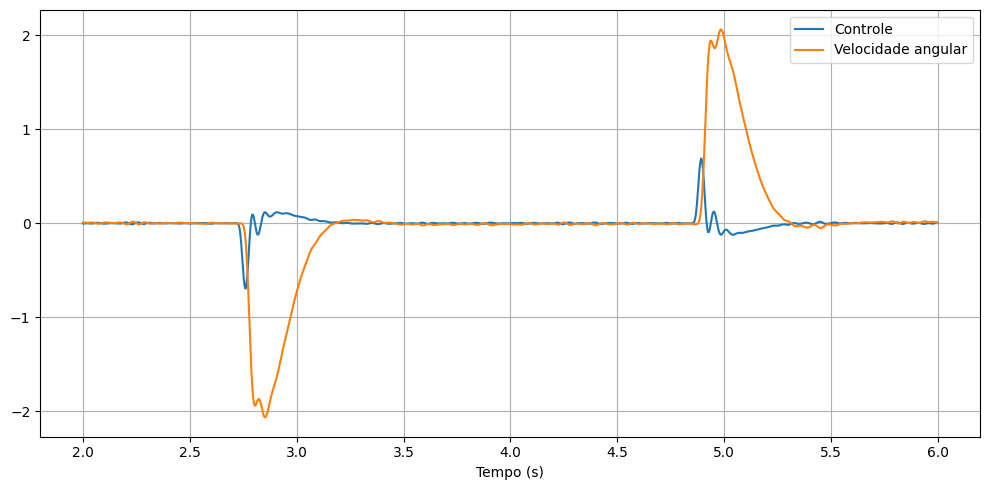

In [5]:
# recortamos os sinais
t0 = 2
tf = 6
dt = t_controle[1] - t_controle[0]
n0 = int(t0/dt)
nf = int(tf/dt)
t_controle_clipped = t_controle[n0:nf]
controle_clipped = controle[n0:nf]
vav0_clipped = vav0[n0:nf]
#
# plotamos os dados recortados
plt.figure(figsize=(10, 5))
plt.plot(t_controle_clipped, controle_clipped, label='Controle')
plt.plot(t_controle_clipped, vav0_clipped, label='Velocidade angular')
plt.grid()
plt.xlabel('Tempo (s)')
plt.legend()
plt.tight_layout()
plt.show()

3. Ajustamos os dados utilizando mínimos quadrados.

Aplicamos o método dos mínimos quadrados para ajustar os parâmetros do modelo para representar o melhor possível os dados obtido a partir do experimento.

Passos:
1. Preparar o sinal de entrada.
2. Preparar a ODE que representa o modelo e a função para a minimização
3. Escolher os valores mínimos e máximos dos parâmetros e o chute inicial.
4. Ajustar os parâmetros do método dos mínimos quadrados.
5. Rodar a otimização.
6. Verificar o resultado.
7. Se satisfeito, salvar os parâmetros.
---

1. Preparar o sinal de entrada $\hat{u}(t):=K_2\dot{u}(t-\tau_2)$.

In [6]:
dcontrole = np.gradient(controle_clipped, dt)
# filtrar a derivada do sinal de controle
fc = 100 # (Hz) frequência de corte da derivada do sinal de controle.
dcontrole_filt = butter_lowpass_filter(dcontrole, fc, 1/dt)

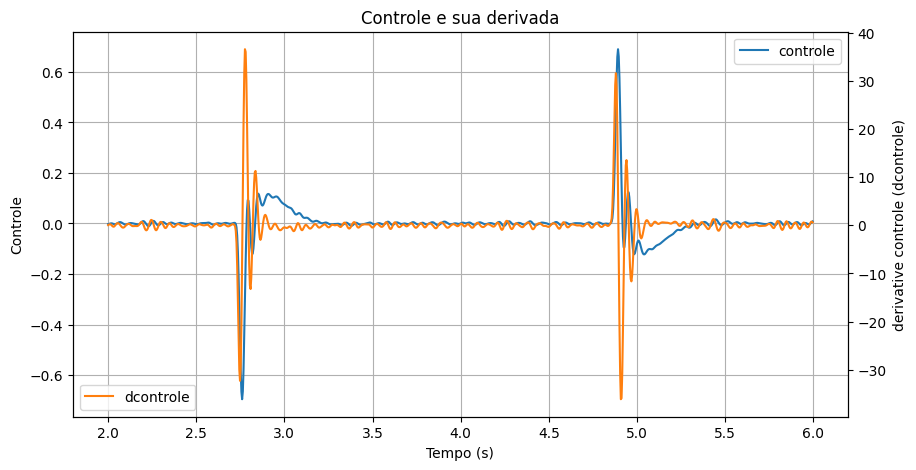

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(t_controle_clipped, controle_clipped, label='controle', color='tab:blue')
ax1.set_xlabel('Tempo (s)')
ax1.set_ylabel('Controle')
ax1.set_title('Controle e sua derivada')
ax1.legend(loc='upper right')
ax1.grid()
#
ax2 = ax1.twinx()
ax2.plot(t_controle_clipped, dcontrole_filt, label='dcontrole', color='tab:orange')
ax2.set_xlabel('Tempo (s)')
ax2.set_ylabel('derivative controle (dcontrole)')
ax2.legend(loc='lower left')
plt.show()

In [8]:
# interpolação do sinal de controle
controle_interp = interp1d(t_controle_clipped, controle_clipped, kind='linear', fill_value='extrapolate')
#dcontrole_interp = interp1d(t_controle_clipped, dcontrole_filt, kind='linear', fill_value='extrapolate') # A derivada do sinal de controle foi filtrada
dcontrole_interp = interp1d(t_controle_clipped, dcontrole, kind='linear', fill_value='extrapolate')  # A derivada do sinal de controle não foi filtrada
# 
# Sinal de controle u_hat(t)
def u_hat(t, tau2, K2):
    return K2*dcontrole_interp(t-tau2)

2. Preparar a ODE que representa o modelo e a função para a minimização
$$
\begin{align*}
\dot{x}_1&=x_2\\
\dot{x}_2&=-c_1x_2-c_2x_1+\hat{u},
\end{align*}
$$

In [9]:
# definição da ODE
def ode_p(t, x, tau2, K2, c1, c2):
        
    dx = np.zeros(2)
    dx[0] = x[1]
    dx[1] = -c1*x[1]-c2*x[0] + u_hat(t, tau2, K2) 
    return dx

# Definição da função f para otimização
def f(tempo, tau2, K2, c1, c2):   
     
    p0 = vav0_clipped[0] # Condição inicial 
    x0 = np.array([p0, 0]) # Condição inicial
    func = lambda t, x: ode_p(t, x, tau2, K2, c1, c2)
    t0 = tempo[0]
    tf = tempo[-1]
    h = tempo[1] - tempo[0]
    _, x =  rk4(func, x0, t0, tf, h)
    return x[:, 0]

3. Escolher os valores mínimos e máximos dos parâmetros $\tau$, $K$, $a$ e $b$.

In [69]:
# valores de referência
#Ixx = 0.016 # Momento de inercia
#tau = 0.0195 # Atraso de tempo

tau2_min = 0.001
tau2_max = 0.050
K2_min   = 1.0
K2_max   = 100
c1_min = 0.01
c1_max = 1.0
c2_min = 0.00001
c2_max = 0.01

param_min = [tau2_min, K2_min, c1_min, c2_min]
param_max = [tau2_max, K2_max, c1_max, c2_max]
bounds = (param_min, param_max)

# Parâmetros iniciais
tau2_0 = uniform(tau2_min, tau2_max)
K2_0 = uniform(K2_min, K2_max)
c1_0 = uniform(c1_min, c1_max)
c2_0 = uniform(c2_min, c2_max)

#
p0 = [tau2_0, K2_0, c1_0, c2_0]

4. Ajustar os parâmetros do método dos mínimos quadrados.

In [52]:
# Parâmetros para a otimização
sigma = None
absolute_sigma = False
# checar se ha algum NaN ou InF nos dados
check_finite = True
# método de otimização (escolher um deles)
# ‘dogbox’ : dogleg algorithm with rectangular trust regions,
# 'trf' : Trust Region Reflective algorithm
method = 'trf'
# Jacobiano
jac = None

5. Rodar a otimização.

In [70]:
popt, pvoc = optimize.curve_fit(f, t_controle_clipped, vav0_clipped, p0, sigma, absolute_sigma, check_finite, bounds, method, jac)
perr = np.sqrt(np.diag(pvoc))

In [71]:
#print('popt =',popt)
print('tau2 (fitted) =',popt[0])
print('K2 (fitted) =',popt[1])
print('c1 (fitted) =',popt[2])
print('c2 (fitted) =',popt[3])
print('perr =',perr)

tau2 (fitted) = 0.03244288001061227
K2 (fitted) = 91.4312714102517
c1 (fitted) = 0.046156874010000466
c2 (fitted) = 1.0000000000000003e-05
perr = [2.89388117e-04 6.27176356e-01 1.53483356e-02 3.29205051e-02]


6. Verificar o resultado.

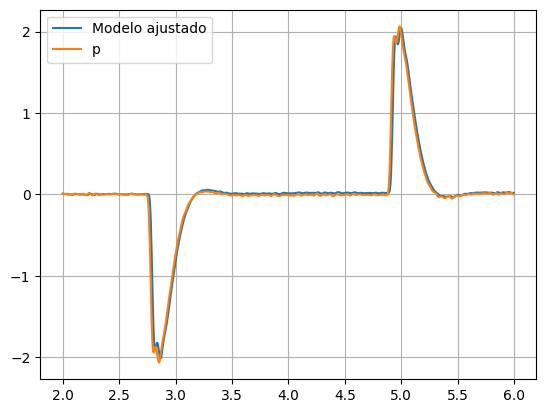

In [72]:
tau2_fitted = popt[0]
K2_fitted = popt[1]
c1_fitted = popt[2]
c2_fitted = popt[3]

plt.plot(t_controle_clipped, f(t_controle_clipped, tau2_fitted, K2_fitted, c1_fitted, c2_fitted), label='Modelo ajustado')
plt.plot(t_controle_clipped, vav0_clipped, label='p')
plt.legend()
plt.grid()
plt.show()


o modelo da dinâmica da taxa p:
$$
\dfrac{P(s)}{U(s)}=\dfrac{K_2se^{-\tau_2 s}}{s^2+c_1s+c_2}
$$

In [73]:

def G2(w, K2, c1,c2, tau2):
    """
    Calculates the transfer function G(s) given the parameters.
    Parameters:
    w (float): The frequency value in rad/s.
    Ixx (float): The moment of inertia value.
    tau (float): The time delay value in seconds.
    a (float): The coefficient value.
    T (float): The time constant value.
    k (float): The gain value.
    Returns:
    complex: The value of G(s) at the given frequency.
    """
    s = complex(0,w)
    return (K2*s*np.exp(-tau2*s))/(s**2 + c1*s + c2)

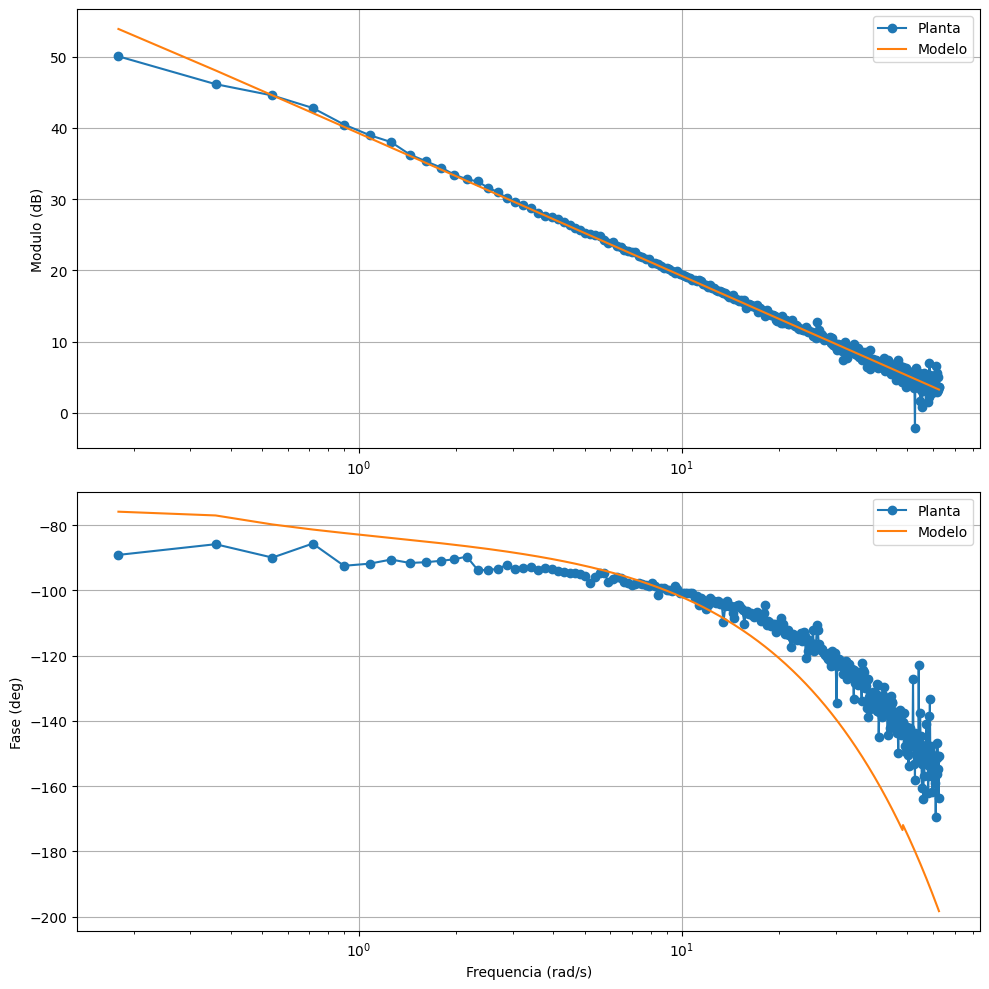

In [74]:
mod_tf_dB, tf_fase = G_bode(freq_rad, lambda w: G2(w, K2=K2_fitted, c1=c1_fitted, c2=c2_fitted, tau2=tau2_fitted))
# Gráfico de Bode
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.semilogx(freq_rad, modulo_dB, label='Planta', marker='o')
ax1.semilogx(freq_rad, mod_tf_dB, label='Modelo')
ax1.grid()
ax1.set_ylabel('Modulo (dB)')
ax1.legend()
ax2.semilogx(freq_rad, fase_deg, label='Planta', marker='o')
ax2.semilogx(freq_rad, np.unwrap(tf_fase), label='Modelo')
ax2.grid()
ax2.set_ylabel('Fase (deg)')
ax2.set_xlabel('Frequencia (rad/s)')
ax2.legend()
plt.tight_layout()
plt.show()


In [76]:
tf_fase


array([ -75.91040627,  -77.0581768 ,  -79.81928454,  -81.37378347,
        -82.44161982,  -83.26529   ,  -83.94919043,  -84.54564455,
        -85.08376279,  -85.58102771,  -86.04857173,  -86.4938199 ,
        -86.9219144 ,  -87.33652917,  -87.74035899,  -88.13542529,
        -88.52327405,  -88.90510784,  -89.28187614,  -89.65433861,
        -90.02311022,  -90.38869418,  -90.75150619,  -91.1118927 ,
        -91.47014472,  -91.8265085 ,  -92.18119383,  -92.53438051,
        -92.88622356,  -93.23685733,  -93.58639884,  -93.93495047,
        -94.28260221,  -94.62943346,  -94.97551453,  -95.32090794,
        -95.66566944,  -96.00984891,  -96.35349112,  -96.69663637,
        -97.03932101,  -97.38157795,  -97.72343703,  -98.06492536,
        -98.40606766,  -98.74688651,  -99.08740254,  -99.42763468,
        -99.76760031, -100.10731543, -100.44679476, -100.78605191,
       -101.12509945, -101.46394904, -101.80261146, -102.14109674,
       -102.47941421, -102.81757255, -103.15557984, -103.49344

In [ ]:
# salvar os parâmetros
#parametros = {
#    'tau': tau_fitted,
#    'K': K_fitted,
#    'a': a_fitted,
#    'b': b_fitted
#}
#
#with open('p_rate_parametros.pkl', 'wb') as f:
#    pickle.dump(parametros, f)